In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import tree
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve

In [6]:
df = pd.read_csv('df_total_sp.csv')
df = df.drop(columns = ['SG_UF','NU_IDADE_N'])

In [7]:
df

,CRITERIO,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,CHIK
0,EpiClinico,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Laboratorial,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,EpiClinico,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0
3,EpiClinico,1,1,1,0,0,0,1,0,1,1,0,0,0,1,0
4,Laboratorial,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761395,Laboratorial,1,1,1,1,1,1,1,0,1,0,0,0,0,1,1
1761396,Laboratorial,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1
1761397,Laboratorial,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1
1761398,Laboratorial,1,1,1,0,0,1,1,0,0,1,0,0,0,1,1


In [8]:
df_lab = df[df['CRITERIO'] == 'Laboratorial']
df_lab = df_lab.reset_index(drop = True)
df_epi = df[df['CRITERIO'] == 'EpiClinico'] 
df_epi = df_epi.reset_index(drop = True)
df_lab = df_lab.drop(columns = ['CRITERIO'])
df_epi = df_epi.drop(columns = ['CRITERIO'])

### Train-test split

In [9]:
X = df_lab.iloc[:,0:13]
y = df_lab.iloc[:,14]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.6, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [10]:
print('Train: ', y_train.shape, sum(y_train == 1), sum(y_train == 0))
print('Test: ', y_test.shape, sum(y_test == 1), sum(y_test == 0))
print('Validation: ', y_val.shape, sum(y_val == 1), sum(y_val == 0))

Train:  (342966,) 2368 340598
Test:  (257225,) 1776 255449
Validation:  (257225,) 1776 255449


### Logistic regression

In [11]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict_proba(X_train)[:,1]
fpr_1, tpr_1, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.7664588783967881


### Random Forest

In [12]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train ,y_train)
y_pred_train = rfc.predict_proba(X_train)[:,1]
fpr_2, tpr_2, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.8216393482932959


### XGBoost

In [13]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train, y_train)
y_pred_train = clx.predict_proba(X_train)[:,1]
fpr_3, tpr_3, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.8027653751636827


### Random forest with class weights 

In [14]:
rfc = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
rfc.fit(X_train ,y_train)
y_pred_train = rfc.predict_proba(X_train)[:,1]
fpr_4, tpr_4, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.8121350690153393


### Training with subsampling

In [15]:
num_train_chik = sum(y_train == 1)
ind_train_chik = (y_train == 1)

In [16]:
X_train_chik = X_train.loc[ind_train_chik]
y_train_chik = y_train.loc[ind_train_chik]
X_train_chik = X_train_chik.reset_index(drop = True)
y_train_chik = y_train_chik.reset_index(drop = True)

In [17]:
ind_train_denv = (y_train == 0)

In [18]:
X_train_denv = X_train.loc[ind_train_denv]
y_train_denv = y_train.loc[ind_train_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.reset_index(drop = True)

In [19]:
indexes_denv = np.random.randint(0,X_train_denv.shape[0],num_train_chik)
X_train_denv = X_train_denv.loc[indexes_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.loc[indexes_denv]
y_train_denv = y_train_denv.reset_index(drop = True)

In [20]:
X_train_2 = pd.concat([X_train_denv, X_train_chik])
y_train_2 = pd.concat([y_train_denv, y_train_chik])

In [21]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train_2, y_train_2)
y_pred_train = logreg.predict_proba(X_train_2)[:,1]
fpr_5, tpr_5, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.7733276456355005


In [22]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train_2 ,y_train_2)
y_pred_train = rfc.predict_proba(X_train_2)[:,1]
fpr_6, tpr_6, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.837363110048393


In [23]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train_2, y_train_2)
y_pred_train = clx.predict_proba(X_train_2)[:,1]
fpr_7, tpr_7, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.8267885574552594


### KNN classifier

In [24]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train, y_train)
y_pred_train = knn.predict_proba(X_train)[:,1]
fpr_8, tpr_8, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.5652717663224046


In [25]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_2, y_train_2)
y_pred_train = knn.predict_proba(X_train_2)[:,1]
fpr_9, tpr_9, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.6758620357583089


### Neural networks (1 layer)

In [26]:
model = Sequential()
model.add(Dense(100, input_dim = 13, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
history = model.fit(X_train_2, y_train_2, epochs = 200, verbose = 1)

Epoch 1/200
148/148 [==============================] - 1s 2ms/step - loss: 0.6311 - auc: 0.7250
Epoch 2/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5701 - auc: 0.7710
Epoch 3/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5657 - auc: 0.7734
Epoch 4/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5645 - auc: 0.7726
Epoch 5/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5616 - auc: 0.7760
Epoch 6/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5597 - auc: 0.7761
Epoch 7/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5585 - auc: 0.7791
Epoch 8/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5577 - auc: 0.7795
Epoch 9/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5560 - auc: 0.7805
Epoch 10/200
148/148 [==============================] - 0s 1ms/step - loss: 0.5552 - auc: 0.7814
Epoch 11/200
148/148 [=================

148/148 [==============================] - 0s 2ms/step - loss: 0.5299 - auc: 0.8028
Epoch 86/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5310 - auc: 0.8014
Epoch 87/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5287 - auc: 0.8035
Epoch 88/200
148/148 [==============================] - 0s 1ms/step - loss: 0.5290 - auc: 0.8036
Epoch 89/200
148/148 [==============================] - 0s 1ms/step - loss: 0.5293 - auc: 0.8036
Epoch 90/200
148/148 [==============================] - 0s 1ms/step - loss: 0.5290 - auc: 0.8034
Epoch 91/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5286 - auc: 0.8042
Epoch 92/200
148/148 [==============================] - 0s 1ms/step - loss: 0.5286 - auc: 0.8042
Epoch 93/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5281 - auc: 0.8044
Epoch 94/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5286 - auc: 0.8035
Epoch 95/200
148/148 [=====================

148/148 [==============================] - 0s 2ms/step - loss: 0.5174 - auc: 0.8119
Epoch 169/200
148/148 [==============================] - 0s 1ms/step - loss: 0.5179 - auc: 0.8109
Epoch 170/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5179 - auc: 0.8111
Epoch 171/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5178 - auc: 0.8103
Epoch 172/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5167 - auc: 0.8119
Epoch 173/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5159 - auc: 0.8130
Epoch 174/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5166 - auc: 0.8125
Epoch 175/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5170 - auc: 0.8126
Epoch 176/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5162 - auc: 0.8121
Epoch 177/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5164 - auc: 0.8124
Epoch 178/200
148/148 [===========

In [27]:
y_pred_train = model.predict(X_train_2).flatten()
fpr_10, tpr_10, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

148/148 [==============================] - 0s 2ms/step
0.8194812805309534


### Neural networks (2 layers)

In [30]:
model = Sequential()
model.add(Dense(100, input_dim = 13, activation='relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
history = model.fit(X_train_2, y_train_2, epochs = 200, verbose = 1)

Epoch 1/200
148/148 [==============================] - 1s 2ms/step - loss: 0.5910 - auc: 0.7544
Epoch 2/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5652 - auc: 0.7721
Epoch 3/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5609 - auc: 0.7752
Epoch 4/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5579 - auc: 0.7780
Epoch 5/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5566 - auc: 0.7791
Epoch 6/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5545 - auc: 0.7809
Epoch 7/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5538 - auc: 0.7827
Epoch 8/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5507 - auc: 0.7855
Epoch 9/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5505 - auc: 0.7857
Epoch 10/200
148/148 [==============================] - 0s 2ms/step - loss: 0.5480 - auc: 0.7871
Epoch 11/200
148/148 [=================

148/148 [==============================] - 0s 2ms/step - loss: 0.4957 - auc: 0.8258
Epoch 86/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4955 - auc: 0.8258
Epoch 87/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4965 - auc: 0.8264
Epoch 88/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4942 - auc: 0.8262
Epoch 89/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4943 - auc: 0.8284
Epoch 90/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4949 - auc: 0.8264
Epoch 91/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4937 - auc: 0.8268
Epoch 92/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4940 - auc: 0.8263
Epoch 93/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4941 - auc: 0.8269
Epoch 94/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4940 - auc: 0.8273
Epoch 95/200
148/148 [=====================

148/148 [==============================] - 0s 2ms/step - loss: 0.4841 - auc: 0.8317
Epoch 169/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4851 - auc: 0.8312
Epoch 170/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4834 - auc: 0.8326
Epoch 171/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4846 - auc: 0.8316
Epoch 172/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4835 - auc: 0.8326
Epoch 173/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4839 - auc: 0.8326
Epoch 174/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4843 - auc: 0.8313
Epoch 175/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4849 - auc: 0.8321
Epoch 176/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4841 - auc: 0.8320
Epoch 177/200
148/148 [==============================] - 0s 2ms/step - loss: 0.4834 - auc: 0.8327
Epoch 178/200
148/148 [===========

In [31]:
y_pred_train = model.predict(X_train_2).flatten()
fpr_11, tpr_11, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

148/148 [==============================] - 1s 3ms/step
0.839451145481419


### Plotting all classifiers

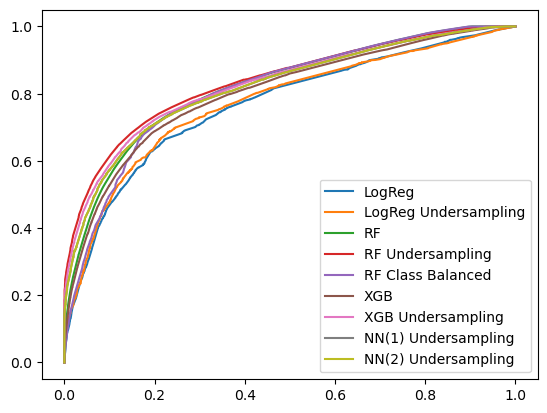

In [33]:
plt.plot(fpr_1, tpr_1, label = 'LogReg')
plt.plot(fpr_5, tpr_5, label = 'LogReg Undersampling')
plt.plot(fpr_2, tpr_2, label = 'RF')
plt.plot(fpr_6, tpr_6, label = 'RF Undersampling')
plt.plot(fpr_4, tpr_4, label = 'RF Class Balanced')
plt.plot(fpr_3, tpr_3, label = 'XGB')
plt.plot(fpr_7, tpr_7, label = 'XGB Undersampling')
#plt.plot(fpr_8, tpr_8, label = 'KNN')
#plt.plot(fpr_9, tpr_9, label = 'KNN Undersampling')
plt.plot(fpr_10, tpr_10, label = 'NN(1) Undersampling')
plt.plot(fpr_10, tpr_10, label = 'NN(2) Undersampling')
plt.legend()
plt.show()